# 1. Multi-Armed Bandit - Overview

An important challenge in many recommendation settings is that new users and items constantly appear in the system and it is important for the recommender system to constantly adapt to the changing patterns in the data. Therefore, unlike offline recommendation algorithms, the approach needs to simultaneously **explore** and **exploit** the search space of recommendations. The main challenge in these systems is that new users and new articles constantly enter the system; therefore, one must **simultaneously** **learn** the user interests and exploit these interests during the operation of the system. This problem is related to *Reinforcement Learning* and an important class of reinforcement learning algorithms is that of the **multi-armed bandit algorithms**.

This class of algorithms derives its name from the fact that one can view the recommender system in a manner similar to a gambler in a casino, who is faced with a choice of a number of slot machines (recommendation algorithms or strategies) and the strategies correspond to the choices a user have. 

![mab](img/mab-analogy.png)

If we think of a the example of web pages, when a user clicks on the link of a recommended page, the recommender system receives a *payoff* in terms of the success of the recommendation. In the simplest case, the click-through problem is modeled with binary payoffs, where a click amounts to a payoff of $1$ unit.

In most practical settings, additional contextual information may be available to the recommender system about the user or the context of the recommendation. Some examples of such contextual information are as follows:
1. A set of features describing the profile of the user or the item-context may be available.
2. The users may be clustered into groups, and the cluster identifier of the group may be used as semantic knowledge about the user.

In cases where contextual information is available about the users, it is often assumed that user identification mechanisms are available.


## 1.1. A Naive MAB Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Environment(object):
    def __init__(self, reward_probabilities, actual_rewards):
        if len(reward_probabilities) != len(actual_rewards):
            raise Exception(f"size of reward_probabilities : {len(reward_probabilities)} does not match size of actual rewards : {len(actual_rewards)}")

        self.reward_probabilities = reward_probabilities
        self.actual_rewards = actual_rewards
        self.k_arms = len(reward_probabilities)

    def choose_arm(self, arm):
        if arm < 0 or arm >= self.k_arms:
            raise Exception(f"arm must be between 0 and {self.k_arms -1}")

        return self.actual_rewards[arm] if np.random.random() < self.reward_probabilities[arm] else 0.0

In [3]:
# Explore the probabilities generated
np.random.random()

0.43510564393290696

In [4]:
# Define an environment with rewards (i.e. payoffs) being 1 and random estimated reward probabilities
env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])

# NOTE:
# - In real life, the model learns the reward probabilities

In [5]:
# Pull arm 1 for 10 times
[env.choose_arm(1) for _ in range(10)]

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

In [6]:
# Pull arm 2 for 10 times
[env.choose_arm(2) for _ in range(10)]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [7]:
# Pull arm 0 for 10 times
[env.choose_arm(0) for _ in range(10)]

[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0]

## 1.2. The Random Agent Algorithm

In this approach, the gambler plays each machine for a **fixed number of trials** in the exploration phase. Subsequently, the machine with the highest payoff is used forever in the exploitation phase. Although this approach might seem reasonable at first sight, it has a number of drawbacks. 

- **Problem 1.** <br>
It is hard to determine the number of trials at which one can confidently predict whether a particular machine is better than the other. The process of estimation of payoffs might take a long time, especially in cases where the payoff events and non-payoff events are very unevenly distributed. For example, in a Web recommendation algorithm, the percentage of click-throughs might be low, as a result of which many trials will be required before one can confidently state whether one recommendation algorithm is better than the other. Using many exploratory trials will waste a significant amount of effort on suboptimal strategies.

- **Problem 2.** <br>
If the wrong strategy is selected in the end, the gambler will use the wrong slot machine forever. In practice, the payoffs of various machines (recommendation algorithms) might evolve over time.

In [8]:
class RandomAgent(object):

  def __init__(self, env, max_iterations=500):
    self.env = env
    self.iterations = max_iterations

    self.q_values = np.zeros(self.env.k_arms)    # Estimated reward probabilities
    self.arm_counts = np.zeros(self.env.k_arms)
    self.arm_rewards = np.zeros(self.env.k_arms)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(self.iterations):
      # Randomly choosing arm; no exploitation of the environment
      arm = np.random.choice(self.env.k_arms)
      reward = self.env.choose_arm(arm)

      self.arm_counts[arm] = self.arm_counts[arm] + 1
      self.arm_rewards[arm] = self.arm_rewards[arm] + reward

      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

    return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}

In [9]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
random_agent = RandomAgent(test_env)
random_agent_result = random_agent.act()

total_rewards = sum(random_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 243.0


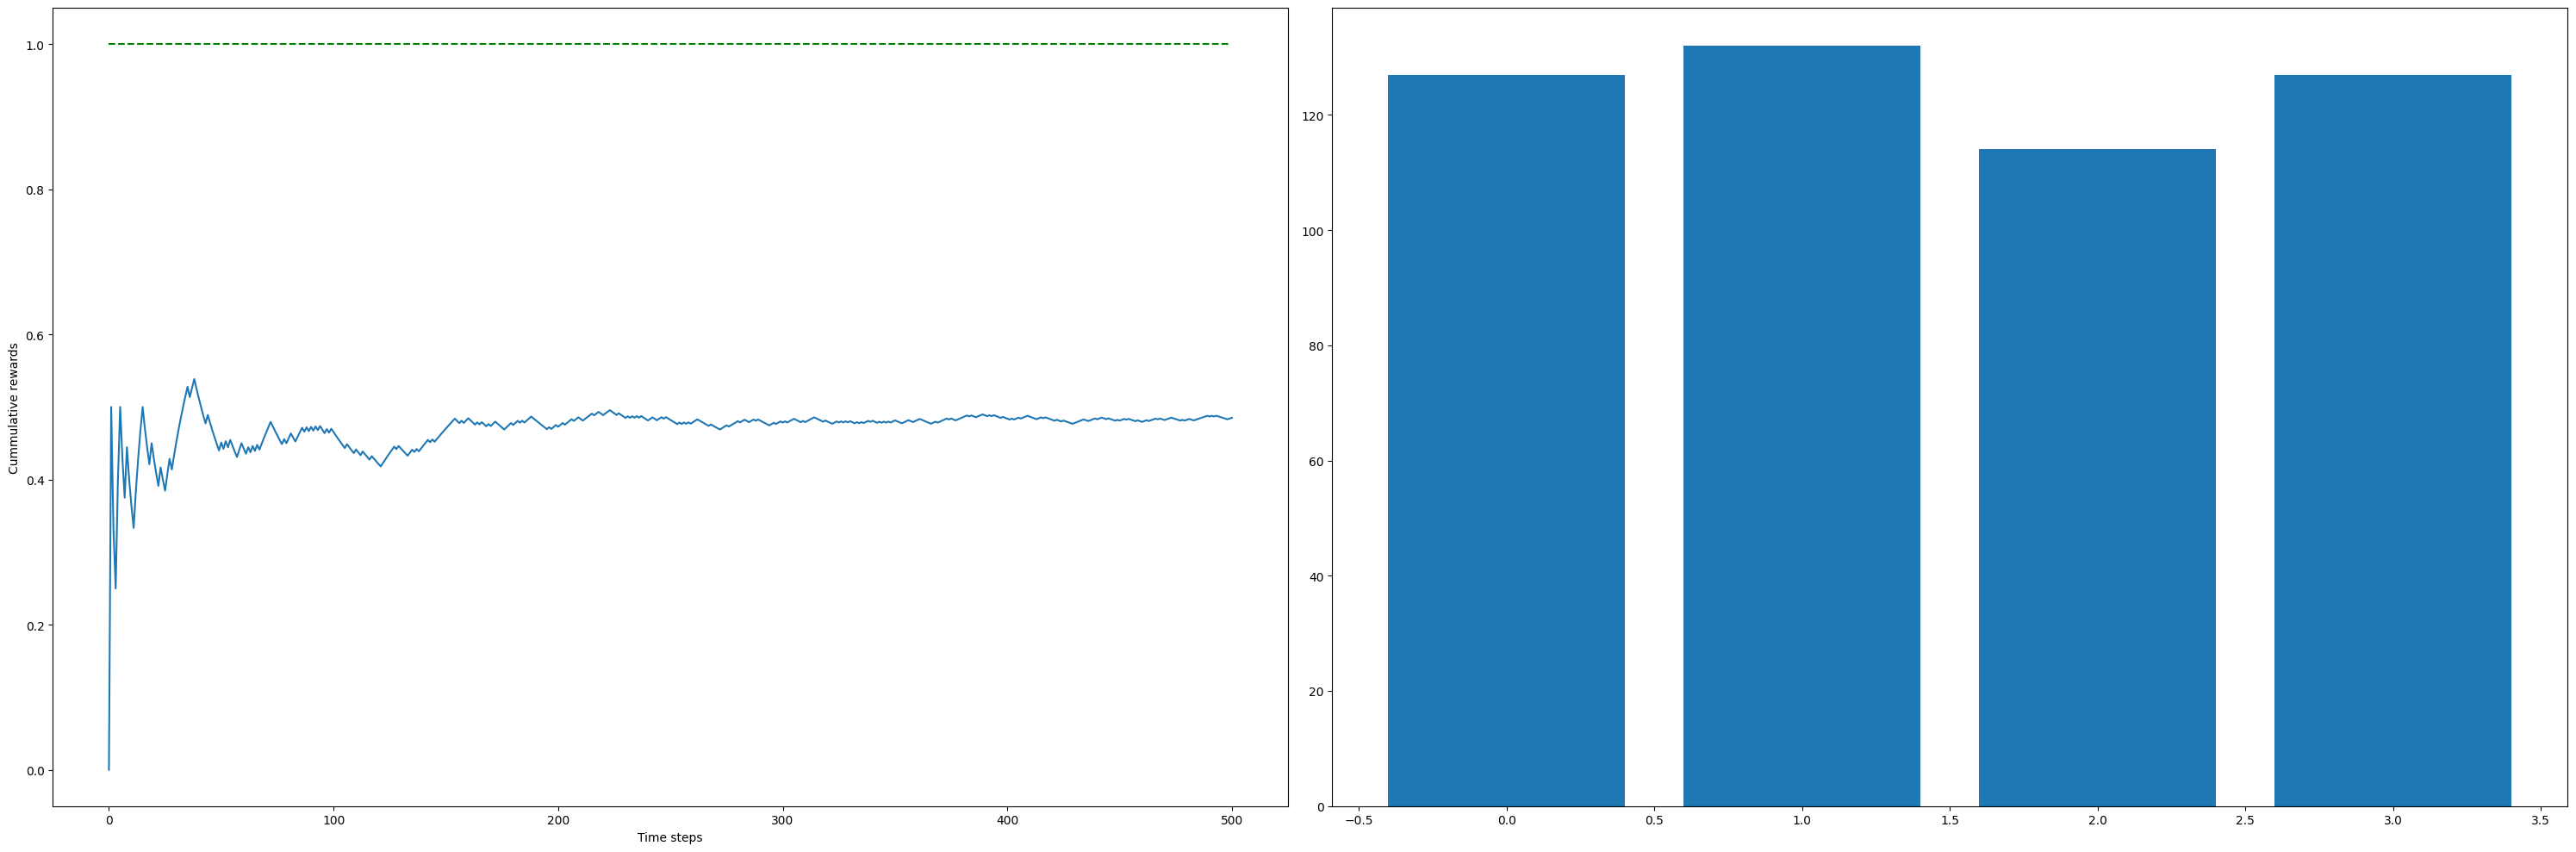

In [10]:
cum_rewards = random_agent_result["cum_rewards"]
arm_counts = random_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(random_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)
plt.tight_layout()

## 1.3. A Greedy Agent

In [11]:
class GreedyAgent(object):

    def __init__(self, env, max_iterations=500):
        self.env = env
        self.iterations = max_iterations

        self.q_values = np.zeros(self.env.k_arms)  # Estimated reward probabilities
        self.arm_counts = np.zeros(self.env.k_arms)
        self.arm_rewards = np.zeros(self.env.k_arms)

        self.rewards = [0.0]
        self.cum_rewards = [0.0]

    def act(self):
        for _ in range(self.iterations):
            arm = np.argmax(self.q_values)  # Greedy action selection
            reward = self.env.choose_arm(arm)

            self.arm_counts[arm] = self.arm_counts[arm] + 1
            self.arm_rewards[arm] = self.arm_rewards[arm] + reward

            self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
            self.rewards.append(reward)
            self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

        return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}

In [12]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
greedy_agent = GreedyAgent(test_env)
greedy_agent_result = greedy_agent.act()

total_rewards = sum(greedy_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 305.0


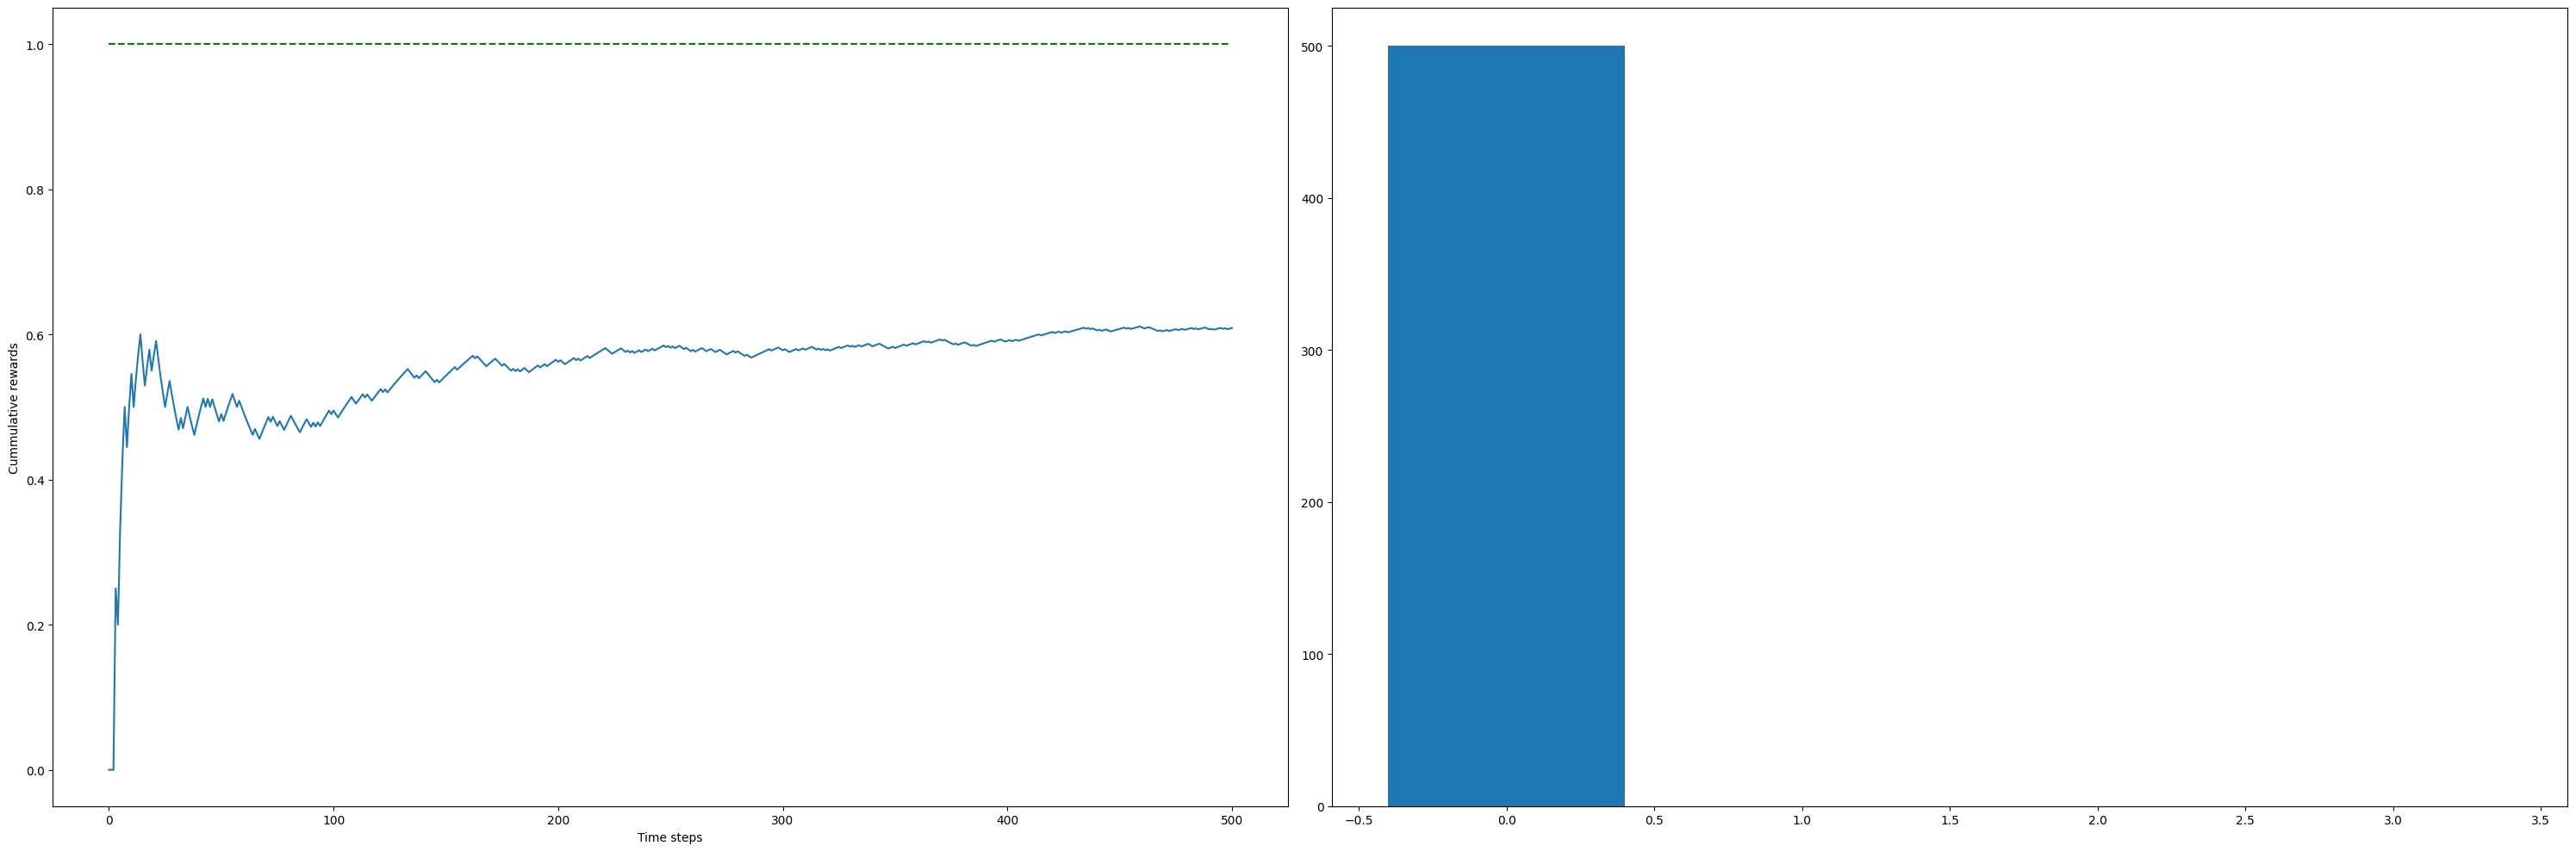

In [13]:
cum_rewards = greedy_agent_result["cum_rewards"]
arm_counts = greedy_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(greedy_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)
plt.tight_layout()

In [14]:
print(f"Environment Reward Probabilities : {test_env.reward_probabilities}")
print(f"Random Agent Action Values : {greedy_agent.q_values}")

Environment Reward Probabilities : [0.62, 0.05, 0.87, 0.49]
Random Agent Action Values : [0.61 0.   0.   0.  ]


## 1.3. The ε-greedy Algorithm

The basic idea is to choose a random slot machine for a fraction ϵ of the trials. These exploratory trials are also chosen at random (with probability ϵ) from all trials, and are therefore fully interleaved with the exploitation trials. In the remaining (1−ϵ) fraction of the trials, the **slot machine with the best average payoff so far is used**. An important advantage of this approach is that one is guaranteed not be trapped in the wrong strategy forever. Furthermore, since the exploitation stage starts early, one is often likely to use the best strategy a large fraction of the time. 

The value of ϵ is an algorithm parameter. For example, in practical settings, one might set ϵ = 0.1, although the best choice of ϵ will vary with the application at hand. It is often difficult to know the best value of ϵ to use in a particular setting.

In [15]:
class EpsilonGreedyAgent(object):

    def __init__(self, env, max_iterations=500, epsilon=0.01, decay_rate=0.01, decay_interval=50):
        self.env = env
        self.iterations = max_iterations
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.decay_interval = decay_interval

        self.q_values = np.zeros(self.env.k_arms)
        self.arm_counts = np.zeros(self.env.k_arms)
        self.arm_rewards = np.zeros(self.env.k_arms)

        self.rewards = [0.0]
        self.cum_rewards = [0.0]

    def act(self):
        for i in range(self.iterations):
            arm = np.random.choice(self.env.k_arms) if np.random.random() < self.epsilon else np.argmax(self.q_values)
            reward = self.env.choose_arm(arm)

            self.arm_counts[arm] = self.arm_counts[arm] + 1
            self.arm_rewards[arm] = self.arm_rewards[arm] + reward

            self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
            self.rewards.append(reward)
            self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

            if i % self.decay_interval == 0:   # Reduce the exploration over time as the system converges after multiple iterations
                self.epsilon = self.epsilon * self.decay_rate

        return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}


In [16]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
egreedy_agent = EpsilonGreedyAgent(test_env, epsilon=0.1, decay_rate=1.0, decay_interval=50)
egreedy_agent_result = egreedy_agent.act()

total_rewards = sum(egreedy_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 396.0


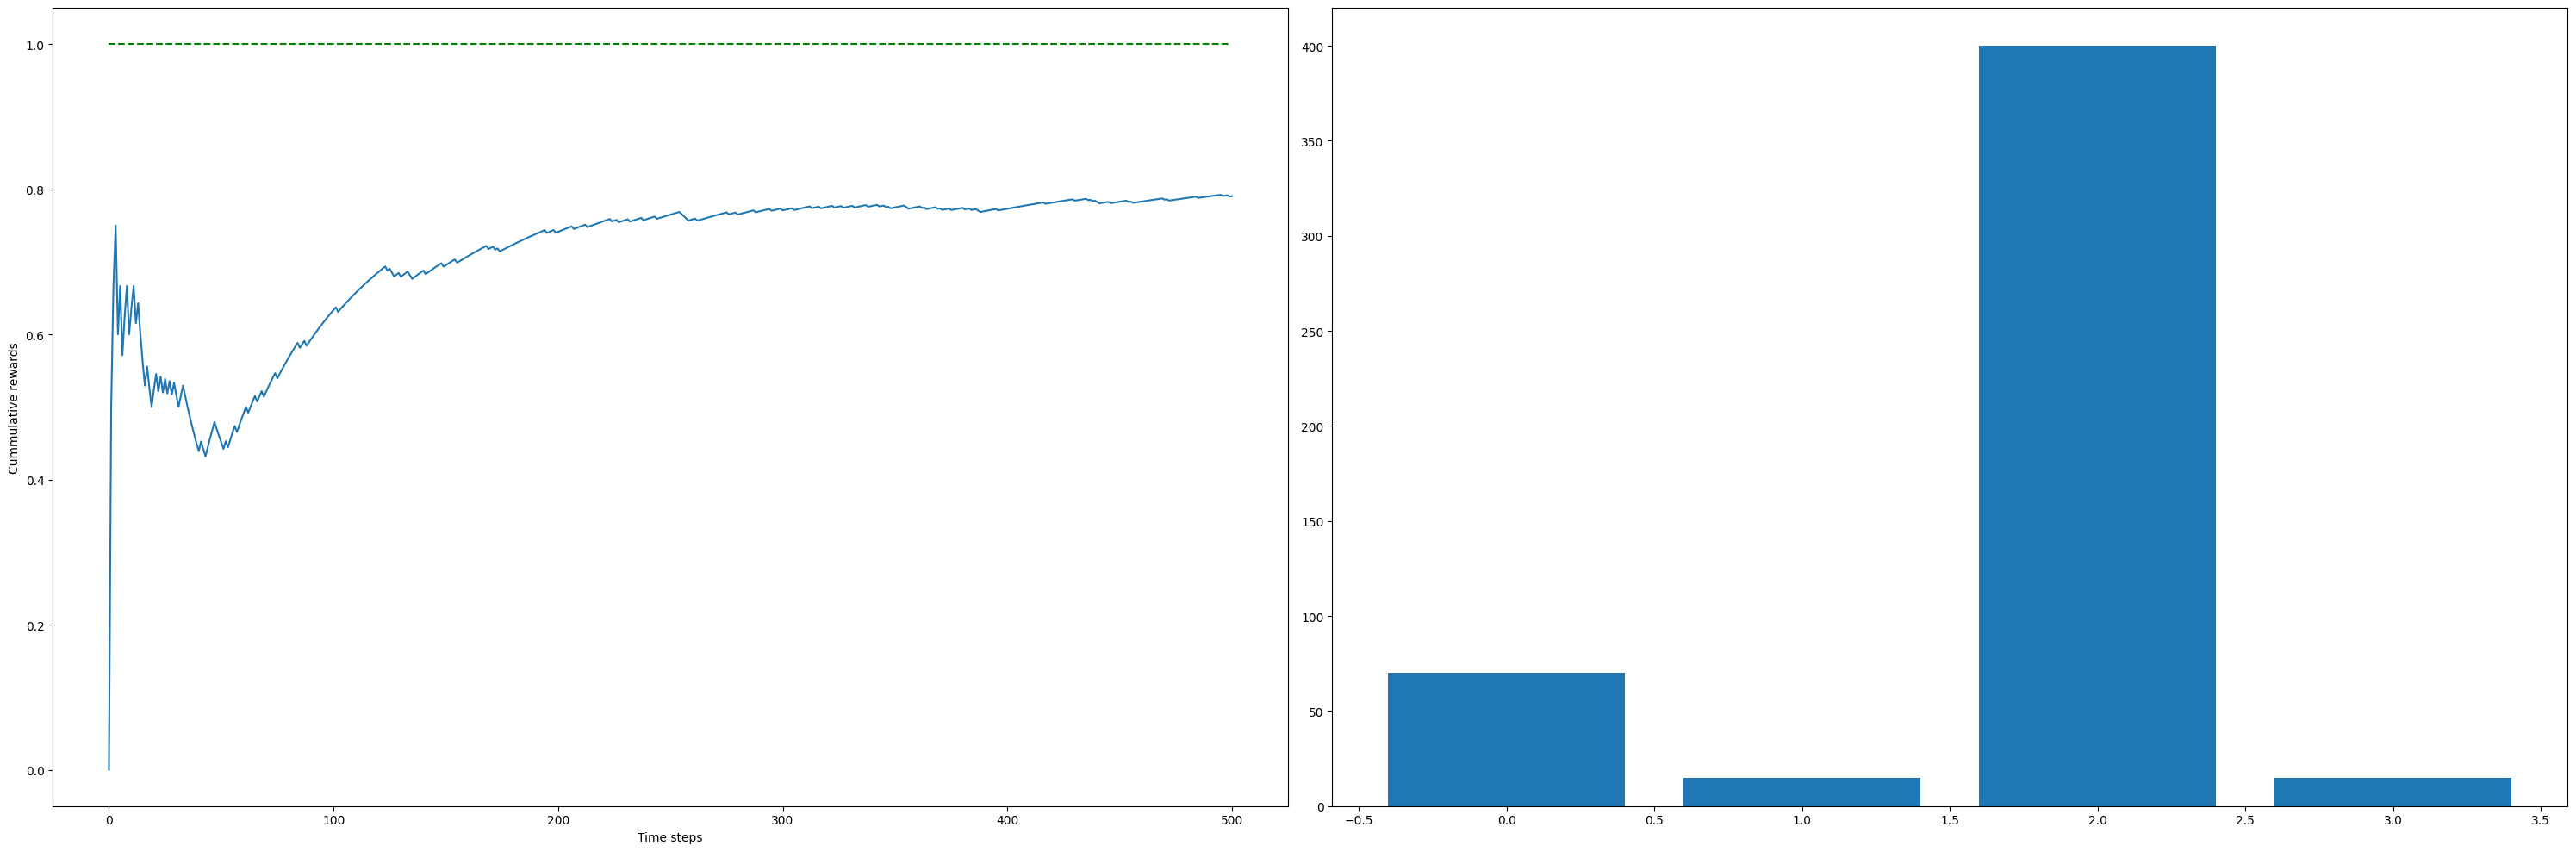

In [17]:
cum_rewards = egreedy_agent_result["cum_rewards"]
arm_counts = egreedy_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(egreedy_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)
plt.tight_layout()

In [ ]:
print(f"Environment Reward Probabilities : {test_env.reward_probabilities}")
print(f"Epsilom Greedy Agent Action Values : {egreedy_agent.q_values}")

Environment Reward Probabilities : [0.62, 0.05, 0.87, 0.49]
Random Agent Action Values : [0.54285714 0.2        0.8675     0.53333333]


## 1.3. The Softmax/Boltzmann Distribution

The Softmax (or Boltzmann Distribution) algorithm is a probabilistic approach to solving Multi-Armed Bandit (MAB) problems. It balances exploration and exploitation by assigning probabilities to arms based on their estimated rewards. Arms with higher rewards are more likely to be selected, but lower-reward arms also have a non-zero probability of being chosen, encouraging exploration. The key idea is that instead of selecting the arm with the highest estimated reward (exploitation) or exploring uniformly (like ε-greedy), the Softmax algorithm explores arms probabilistically based on their relative rewards.

At time $t$, the probability of selecting arm $a_i$ is given by:

$$
P(a_i) = \frac{\exp(\hat{Q}_{a_i} / \tau)}{\sum_{j=1}^{k} \exp(\hat{Q}_{a_j} / \tau)}
$$

where:
- $\hat{Q}_{a_i}$: Estimated reward (or value) of arm $a_i$.
- $\tau$: Temperature parameter (controls exploration vs exploitation).
- $k$: Total number of arms.

The key components of the algorithm are as follows:

1. **Estimated Rewards ($\hat{Q}_{a_i}$):**
   - These are the mean rewards observed for each arm so far.
   - Updated incrementally as: $ \hat{Q}_{a_i} = \hat{Q}_{a_i} + \frac{1}{n_{a_i}} \left( r_t - \hat{Q}_{a_i} \right)$
     where:
     - $n_{a_i}$: Number of times arm $a_i$ has been played.
     - $r_t$: Reward observed after playing $a_i$.

2. **Temperature Parameter ($\tau$):**
   - Controls the degree of exploration:
     - **High $\tau$**: Increases randomness (more exploration).
     - **Low $\tau$**: Reduces randomness (more exploitation).
     - **$\tau \to 0$**: Behaves like a greedy algorithm (always picks the arm with the highest estimated reward).

3. **Boltzmann Distribution:**
   - Normalizes the probabilities of arms so that they sum to 1: $\sum_{i=1}^k P(a_i) = 1$

In [24]:
class SoftmaxExplorationAgent(object):

    def __init__(self, env, max_iterations=500, tau=0.5):
        self.env = env
        self.iterations = max_iterations
        self.tau = tau

        self.action_probas = np.zeros(self.env.k_arms)
        self.q_values = np.zeros(self.env.k_arms)
        self.arm_counts = np.zeros(self.env.k_arms)
        self.arm_rewards = np.zeros(self.env.k_arms)

        self.rewards = [0.0]
        self.cum_rewards = [0.0]

    def act(self):
        for i in range(self.iterations):
            self.action_probas = np.exp(self.q_values/self.tau) / np.sum(np.exp(self.q_values/self.tau))
            arm = np.random.choice(self.env.k_arms, p=self.action_probas)
            reward = self.env.choose_arm(arm)

            self.arm_counts[arm] = self.arm_counts[arm] + 1
            self.arm_rewards[arm] = self.arm_rewards[arm] + reward

            self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])
            self.rewards.append(reward)
            self.cum_rewards.append(sum(self.rewards) / len(self.rewards))

        return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}

In [25]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
softmax_agent = SoftmaxExplorationAgent(test_env, tau=0.015, max_iterations=2000)
softmax_agent_result = softmax_agent.act()

total_rewards = sum(softmax_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

Total Reward : 1733.0


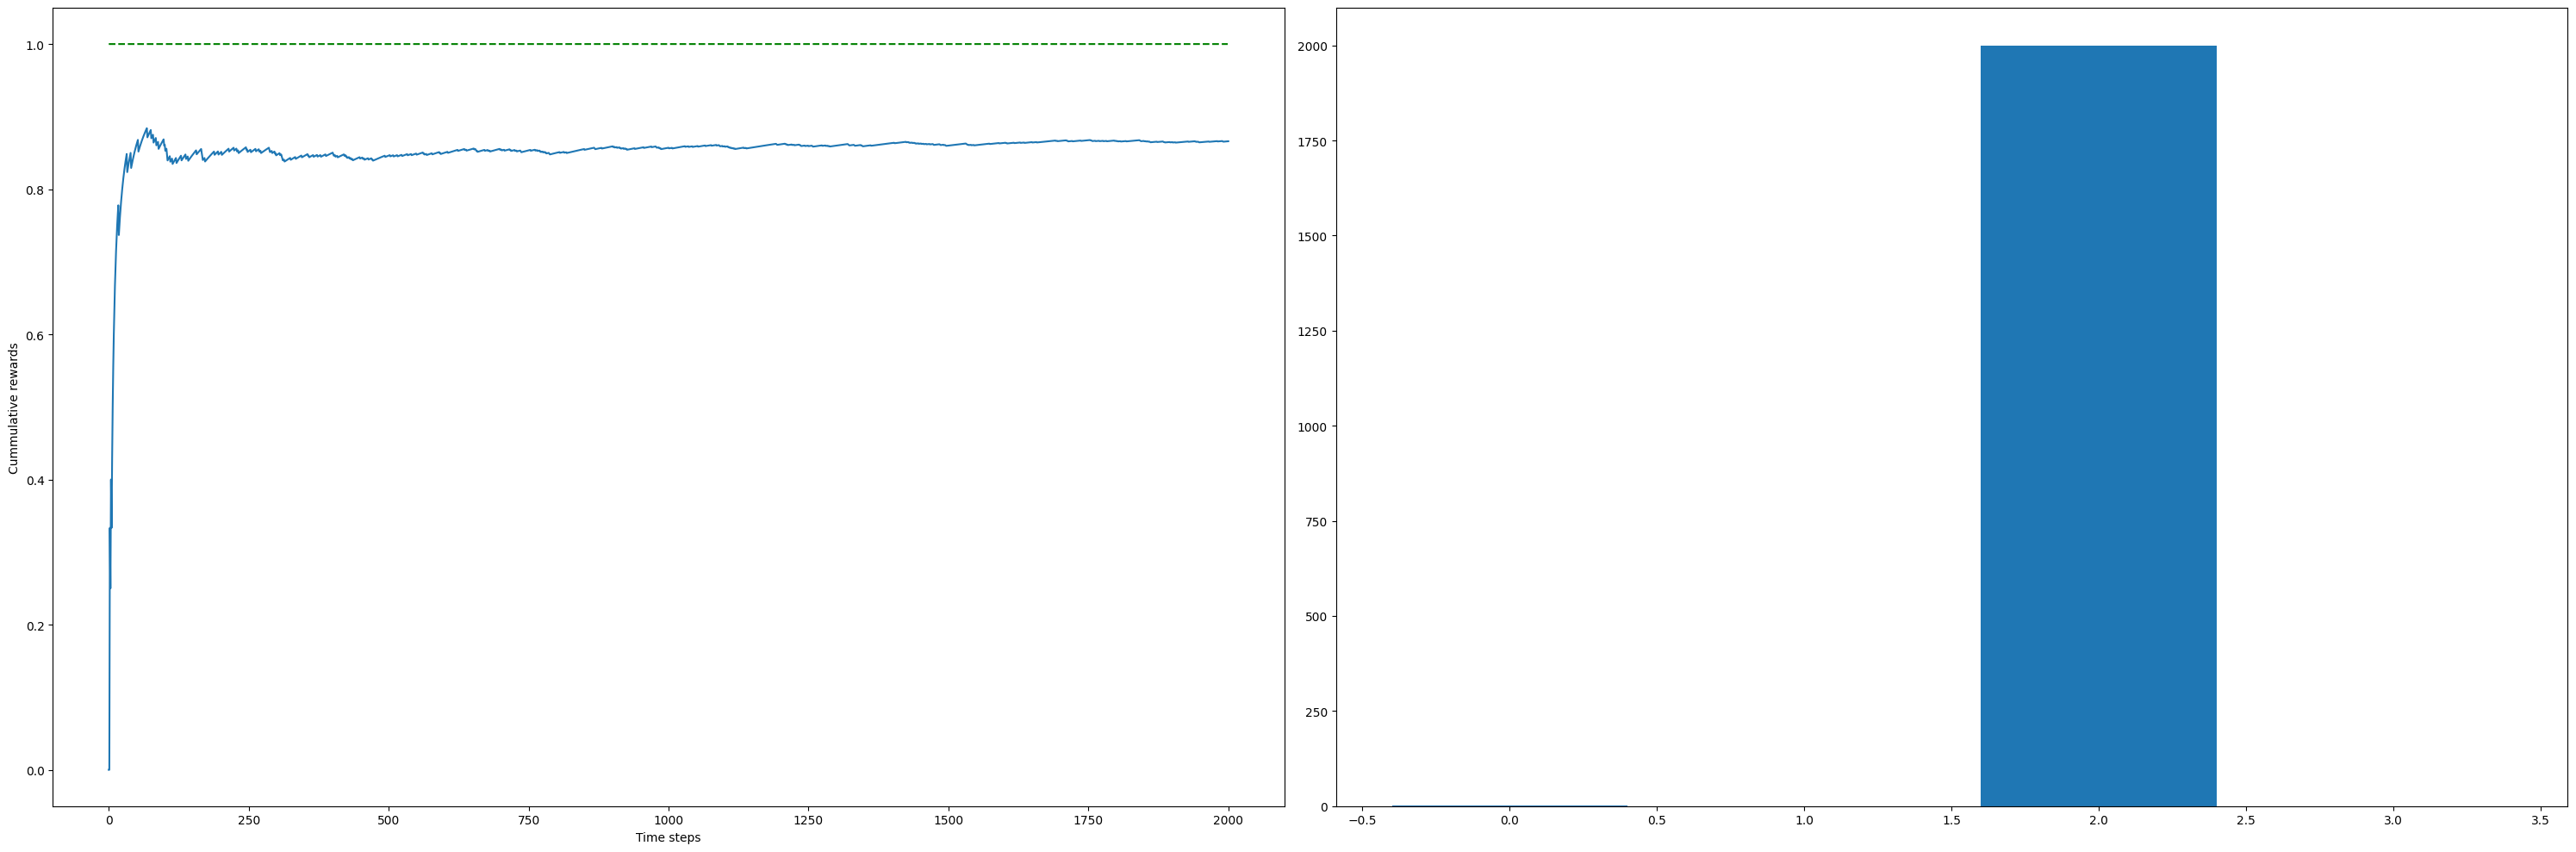

In [26]:
cum_rewards = softmax_agent_result["cum_rewards"]
arm_counts = softmax_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(softmax_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)
plt.tight_layout()

In [27]:
print(f"Environment Reward Probabilities : {test_env.reward_probabilities}")
print(f"Softmax Agent Action Values : {softmax_agent.q_values}")

Environment Reward Probabilities : [0.62, 0.05, 0.87, 0.49]
Softmax Agent Action Values : [0.         0.         0.86693347 0.        ]


## 1.4. Upper Bounding Methods

Even though the ϵ-greedy strategy is better than the naive strategy in dynamic settings, it is still quite inefficient at learning the payoffs of new slot machines. In a dynamic recommendation setting, this problem is pervasive because new items enter the system all the time. In upper bounding strategies, the gambler does not use the mean payoff of a slot machine. Rather, the gambler takes a more optimistic view of slot machines that have not been tried sufficiently, and therefore uses a slot machine with the best statistical upper bound on the payoff. An important problem here is that of determining a statistical upper bound on the payoff of each machine. This can often be achieved with the help of the central limit theorem, which states that the sum of a large number of i.i.d. random variables (payoffs) converges to the normal distribution.

Upper bounding strategies have been used recently for designing recommendation algorithms. Many of these algorithms use the contextual features of the users and recommendation setting to design the various multi-arm bandit strategies for exploration and exploitation of the search space. The basic idea is that the gambler is shown a feature vector relevant to that trial (e.g., user or item profile in recommender system), and the gambler makes decisions on the slot machine (choice of recommendation strategy or choice of item) based on the knowledge of the feature vector. Such algorithms are also referred to as contextual bandit algorithms.

### 1.4.1. The Standard UCB Algorithm

The UCB value for arm $a_i$ at time step $t$ is given by:

$$
UCB(a_i) = \bar{X}_{a_i} + c \sqrt{\frac{2 \ln t}{n_{a_i}}}
$$

1. **Empirical Mean Reward** $\bar{X}_{a_i}$:
   - The average reward observed for arm $a_i$ so far:
   $$
   \bar{X}_{a_i} = \frac{\text{Total rewards for } a_i}{n_{a_i}}
   $$
   where $n_{a_i}$ is the number of times arm $a_i$ has been selected.

2. **Confidence Bound** $c \sqrt{\frac{2 \ln t}{n_{a_i}}}$:
   - Encourages exploration of arms with high uncertainty (i.e., those selected fewer times).
   - $c$ is a hyperparameter that controls the trade-off between exploration and exploitation.

3. **Time Step** ($t$):
   - The current time step (iteration).

4. **Arm Count** ($n_{a_i}$):
   - The number of times arm $a_i$ has been selected.

#### Key Ideas:

1. **Exploration**:
   - Arms with higher uncertainty (i.e., those with lower $n_{a_i}$) are explored more frequently.
   - This is achieved through the $c \sqrt{\frac{2 \ln t}{n_{a_i}}}$ term, which increases for less-selected arms.

2. **Exploitation**:
   - Arms with higher empirical mean rewards ($\bar{X}_{a_i}$) are more likely to be selected.

3. **Trade-off**:
   - The $c$ parameter controls the balance between exploration and exploitation:
     - Higher $c$ increases exploration.
     - Lower $c$ favors exploitation.

#### Limitations:
- Does not leverage contextual information (unlike contextual bandit algorithms like LinUCB).
- Assumes rewards are stochastic and stationary.

In [ ]:
class UCBAgent(object):

  def __init__(self, env, c=2, max_iterations=500):
    self.env = env
    self.c = c
    self.iterations = max_iterations

    self.q_values = np.zeros(self.env.k_arms, dtype=float)
    self.arm_counts = np.zeros(self.env.k_arms, dtype=int)
    self.arm_rewards = np.zeros(self.env.k_arms, dtype=float)

    self.rewards = [0.0]
    self.cum_rewards = [0.0]

  def act(self):
    for i in range(0, self.iterations):
      if i < len(self.q_values):
        arm = i
      else:
        U = self.c * np.sqrt(np.log(i) / self.arm_counts)
        arm = np.argmax(self.q_values + U)

      reward = self.env.choose_arm(arm)

      self.arm_rewards[arm] += reward
      self.arm_counts[arm] += 1
      self.q_values[arm] = self.q_values[arm] + (1/self.arm_counts[arm]) * (reward - self.q_values[arm])

      self.rewards.append(reward)
      self.cum_rewards.append(sum(self.rewards)/len(self.rewards))

    return {"arm_counts" : self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}

In [ ]:
test_env = Environment(reward_probabilities=[0.62, 0.05, 0.87, 0.49], actual_rewards=[1.0, 1.0, 1.0, 1.0])
ucb_agent = UCBAgent(test_env, c=1)
ucb_agent_result = ucb_agent.act()

total_rewards = sum(ucb_agent_result["rewards"])
print(f"Total Reward : {total_rewards}")

In [ ]:
cum_rewards = ucb_agent_result["cum_rewards"]
arm_counts = ucb_agent_result["arm_counts"]

fig = plt.figure(figsize=[30,10])

ax1 = fig.add_subplot(121)
ax1.plot([1.0 for _ in range(ucb_agent.iterations)], "g--", label="target cummulative reward")
ax1.plot(cum_rewards, label="cummulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cummulative rewards")

ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)
plt.tight_layout()

### 1.4.2. The LinUCB Algorithm

The **LinUCB** algorithm is a contextual bandit algorithm that uses a linear regression model to predict the reward of an arm based on contextual features. The payoff of the \(i\)-th arm is estimated as follows:

$$
\text{Payoff}_i = \mathbf{X} \underbrace{\left( \mathbf{D}_i^T \mathbf{D}_i + \lambda \mathbf{I} \right)^{-1} \mathbf{D}_i^T \mathbf{y}_i}_{\text{Regression Coefficients}}
$$

1. **Feature Vector** ($\mathbf{X}$):
   - A $d$-dimensional (row) vector representing the current context.

2. **Feature Matrix** ($\mathbf{D}_i$):
   - A matrix containing the historical context vectors for arm $i$.

3. **Observed Rewards** ($\mathbf{y}_i$):
   - A column vector containing the rewards observed for arm $i$.

4. **Regularization Parameter** ($\lambda$):
   - A scalar controlling the trade-off between bias and variance in ridge regression.

5. **Confidence Adjustment**:
   - LinUCB typically adds a confidence interval to the payoff estimation to balance exploration and exploitation. This can be represented as:
     $$
     \text{UCB}_i = \mathbf{X} \hat{\theta}_i + \alpha \sqrt{\mathbf{X} \left( \mathbf{D}_i^T \mathbf{D}_i + \lambda \mathbf{I} \right)^{-1} \mathbf{X}^T}
     $$
     where \$alpha$ is a hyperparameter controlling the degree of exploration.

#### Key Ideas:

- **Contextual Modeling**:
  The reward for each arm is assumed to depend linearly on the contextual features.

- **Exploration vs. Exploitation**:
  The confidence interval ensures that arms with high uncertainty in reward prediction are explored.

- **Applications**:
  LinUCB is commonly used in recommendation systems, where user and item features are utilized to personalize recommendations.

In [ ]:
class LinUCBAgent:
    def __init__(self, env, alpha=1.0, max_iterations=500):
        """
        LinUCB Agent for Contextual Bandits.
        
        Args:
            env: Environment with k_arms and feature dimension d.
            alpha: Exploration parameter (controls exploration vs exploitation).
            max_iterations: Number of iterations to run the algorithm.
        """
        self.env = env
        self.alpha = alpha
        self.iterations = max_iterations
        
        self.d = env.feature_dim  # Dimensionality of feature vectors
        self.k = env.k_arms  # Number of arms
        
        # Initialize parameters for each arm
        self.A = [np.eye(self.d) for _ in range(self.k)]  # Identity matrix (d x d) for each arm
        self.b = [np.zeros(self.d) for _ in range(self.k)]  # Zero vector (d x 1) for each arm
        
        # Track rewards and arm counts
        self.arm_counts = np.zeros(self.k, dtype=int)
        self.rewards = []
        self.cum_rewards = []
        
    def act(self):
        """
        Runs the LinUCB algorithm over the defined number of iterations.
        
        Returns:
            A dictionary containing arm counts, rewards, and cumulative rewards.
        """
        for t in range(self.iterations):
            # Get the current context (feature vector)
            context = self.env.get_context()  # Shape: (k, d) - feature matrix for all arms
            
            # Compute the upper confidence bound (UCB) for each arm
            ucb_values = []
            for i in range(self.k):
                A_inv = np.linalg.inv(self.A[i])  # Inverse of A matrix
                theta_i = A_inv @ self.b[i]  # Regression coefficients for arm i
                
                # Expected reward and confidence bound
                payoff_estimate = context[i] @ theta_i
                confidence = self.alpha * np.sqrt(context[i] @ A_inv @ context[i])
                ucb_values.append(payoff_estimate + confidence)
            
            # Select the arm with the highest UCB
            chosen_arm = np.argmax(ucb_values)
            
            # Pull the chosen arm and observe the reward
            reward = self.env.choose_arm(chosen_arm)  # Reward for the selected arm
            
            # Update the parameters of the chosen arm
            x_t = context[chosen_arm]  # Feature vector for the chosen arm
            self.A[chosen_arm] += np.outer(x_t, x_t)  # Update A matrix
            self.b[chosen_arm] += reward * x_t  # Update b vector
            
            # Track rewards and arm counts
            self.arm_counts[chosen_arm] += 1
            self.rewards.append(reward)
            self.cum_rewards.append(sum(self.rewards) / len(self.rewards))
        
        return {"arm_counts": self.arm_counts, "rewards": self.rewards, "cum_rewards": self.cum_rewards}


In [ ]:
# Define the environment
class Environment:
    def __init__(self, feature_matrix, true_coefficients, noise_std=0.1):
        """
        Environment for the LinUCB algorithm.
        
        Args:
            feature_matrix: A (k, d) matrix where each row represents the feature vector for an arm.
            true_coefficients: A (d, ) vector representing the true coefficients for generating rewards.
            noise_std: Standard deviation of Gaussian noise added to the reward.
        """
        self.feature_matrix = feature_matrix
        self.true_coefficients = true_coefficients
        self.noise_std = noise_std
        self.k_arms = feature_matrix.shape[0]
        self.feature_dim = feature_matrix.shape[1]
    
    def get_context(self):
        """Return the feature matrix."""
        return self.feature_matrix
    
    def choose_arm(self, arm_index):
        """Generate a reward for the chosen arm."""
        x = self.feature_matrix[arm_index]
        mean_reward = x @ self.true_coefficients
        reward = mean_reward + np.random.normal(0, self.noise_std)
        return reward

In [ ]:
# Set up the environment and LinUCB agent
np.random.seed(42)  # For reproducibility
k_arms = 4
d_features = 5
feature_matrix = np.random.rand(k_arms, d_features)
true_coefficients = np.random.rand(d_features)
noise_std = 0.1

test_env = Environment(feature_matrix, true_coefficients, noise_std)
linucb_agent = LinUCBAgent(test_env, alpha=1.0, max_iterations=500)

# Run the LinUCB agent
linucb_result = linucb_agent.act()

# Visualize the results
total_rewards = sum(linucb_result["rewards"])
print(f"Total Reward: {total_rewards}")

In [ ]:
cum_rewards = linucb_result["cum_rewards"]
arm_counts = linucb_result["arm_counts"]

fig = plt.figure(figsize=[20, 8])

# Plot cumulative rewards
ax1 = fig.add_subplot(121)
ax1.plot(cum_rewards, label="Cumulative rewards")
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Cumulative rewards")
ax1.legend()

# Plot arm counts
ax2 = fig.add_subplot(122)
ax2.bar([i for i in range(len(arm_counts))], arm_counts)
ax2.set_xlabel("Arm")
ax2.set_ylabel("Number of times each arm was selected")
ax2.set_title("Arm selection counts")

plt.tight_layout()

Consider a setting where the arms of the slot machines correspond to recommending different items. The basic idea of these algorithms is to use the following steps repeatedly:

1. (Incremental) training: Train a classification or regression learning model based on past history of feature-payoff pairs to learn the expected payoff of each arm. In most cases, this phase is executed incrementally, as new feature-payoff pairs enter the system over the time. Whenever a particular arm is selected by the recommender system, its feature attributes and payoff value is added to a training data set that is specific to the corresponding arm. Therefore, there are as many training data sets (and incrementally updated models) as the number of arms. The number of training examples for each arm is equal to the number of times that the arm was played in the past. A separate model is constructed for each arm using its training data. It is desired to use a probabilistic or statistical learning algorithm that outputs the expected payoff and an estimated standard deviation (or maximum deviation) measure of the payoff of each arm (item) for a particular feature vector (context). Note that arms corresponding to newly added items will have smaller training data sets. Smaller training data sets will lead to larger estimated deviation of prediction. In general, there are two criteria to keep in mind while selecting the base model for payoff prediction:
   - The base model should be incrementally updatable because new feature-payoff pairs are continually added to the training data.
   - The base model should have the ability to output some measure of (or tight upper bound on) the expected error of prediction.

2. Upper-bound estimation: For the current contextual profile being shown to the recommender system, use the learned model to construct an upper bound on the expected payoff of each arm. The upper bound is computed as a linear sum of the
expected payoff and an appropriate multiple of the standard deviation. In some cases, a tight upper bound on the maximum deviation is used instead of the standard deviation. The choice of deviation measure often depends on the ease of computing such measures with the model at hand.

3. Recommendation: Select the arm with the largest upper bound. Recommend the corresponding item to the user.